# Exploratory Data Analysis - Insurance App Ratings on Google Play Store

In this notebook, we will 
1. split the data into train & test set
2. explore the trends in sentiment by company and year
3. look for most common words by sentiment
3. & unique words which are present in only positive or negative sentiments.

We will use the cleaned dataset from the Data Wrangling Notebook.

In [1]:
import pandas as pd
import numpy as np
import time
import string
from datetime import datetime
from pathlib import Path
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import unicodedata
import spacy
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setup Seaborn
plt.style.use('fivethirtyeight')

# For process develpment
development_flag =  False

random_seed = 79

In [2]:
clean_review = '../data/interim/clean_review.csv'
df_reviews = pd.read_csv(clean_review)
df_reviews.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company,year,rating,clean_review,clean_review_len
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,5,0,NaN,2021-08-26 22:29:04,NaN,NaN,icici.lombard.ghi,icici_lombard,2021,0,service reaction please keep work not let cust...,8
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",5,0,NaN,2021-08-26 22:28:35,NaN,NaN,icici.lombard.ghi,icici_lombard,2021,0,app simple tidy focus need consumer app make s...,15
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,5,0,NaN,2021-08-26 22:27:21,NaN,NaN,icici.lombard.ghi,icici_lombard,2021,0,simple select purchase app allow renew bike pr...,11
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,5,0,NaN,2021-08-26 22:26:59,NaN,NaN,icici.lombard.ghi,icici_lombard,2021,0,use app car time always receive service proced...,10
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,1,0,2.0.40,2021-08-26 21:21:10,NaN,NaN,icici.lombard.ghi,icici_lombard,2021,1,wrost company one friend abhishek gupta purcha...,22


In [3]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10640 entries, 0 to 10639
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10640 non-null  object
 1   review                10640 non-null  object
 2   score                 10640 non-null  int64 
 3   thumbsUpCount         10640 non-null  int64 
 4   reviewCreatedVersion  9281 non-null   object
 5   at                    10640 non-null  object
 6   replyContent          8046 non-null   object
 7   repliedAt             8046 non-null   object
 8   appId                 10640 non-null  object
 9   company               10640 non-null  object
 10  year                  10640 non-null  int64 
 11  rating                10640 non-null  int64 
 12  clean_review          10640 non-null  object
 13  clean_review_len      10640 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 1.1+ MB


Converting to datetime format

In [4]:
df_reviews.loc[:,'at'] = pd.to_datetime(df_reviews.loc[:,'at'])
df_reviews.loc[:,'repliedAt'] = pd.to_datetime(df_reviews.loc[:,'repliedAt'])

In [5]:
df_reviews.groupby(['company']).rating.mean()

company
acko             0.467890
bajaj_allianz    0.677499
hdfc_ergo        0.855354
icici_lombard    0.493545
Name: rating, dtype: float64

## Train Test Split

We will split the data using stratified sampling on
1. rating 
2. company  
to ensure a representative test set.

In [6]:
df_train, df_test = train_test_split(df_reviews, test_size=0.25, 
                                     stratify = df_reviews[['rating','company']], random_state = random_seed)

df_train.shape, df_test.shape

((7980, 14), (2660, 14))

In [7]:
df_train.groupby(['company']).rating.mean()

company
acko             0.467890
bajaj_allianz    0.677455
hdfc_ergo        0.855417
icici_lombard    0.493609
Name: rating, dtype: float64

In [8]:
df_test.groupby(['company']).rating.mean()

company
acko             0.467890
bajaj_allianz    0.677632
hdfc_ergo        0.855165
icici_lombard    0.493353
Name: rating, dtype: float64

In [9]:
df_test.groupby(['company']).rating.count()

company
acko             436
bajaj_allianz    608
hdfc_ergo        939
icici_lombard    677
Name: rating, dtype: int64

In [10]:
df_text  = df_train.loc[:,['reviewId','rating','company','year','clean_review']].copy()
map_sentiment = {0:'Positive', 1:'Negative'}
df_text.loc[:,'rating'] = df_text.loc[:,'rating'].map(map_sentiment)

df_text.rating.value_counts()

Negative    5259
Positive    2721
Name: rating, dtype: int64

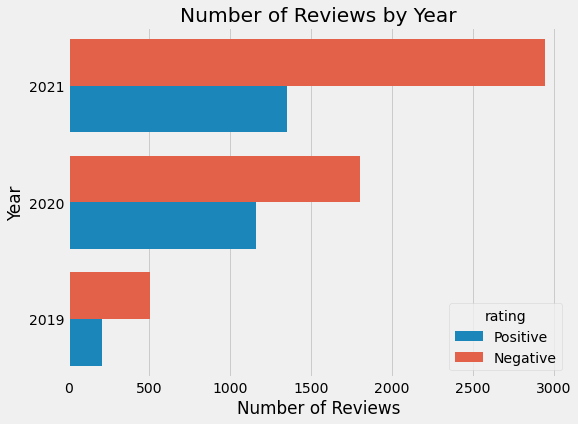

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

palette ={"Negative": "r", "Positive": "b"}

ax = sns.countplot(y='year', data= df_text, hue = 'rating', hue_order = ['Positive','Negative'])
ax.invert_yaxis()
plt.ylabel('Year')
plt.xlabel('Number of Reviews')
plt.title('Number of Reviews by Year');


Number of reviews increased over the years. In 2021, the negative sentiments are twice the positive ones. While in 2019, negative reviews are ~ 1.5 times positive reviews. This is a clear setback for the industry. Let us look at this trend by each company.

In [12]:
df_company_yr = df_text.groupby(['company','year','rating']).agg({'clean_review':'count'}).reset_index()

In [13]:
def plot_company_year(company = None, company_name= None):
    """
    plots count of positive & negative reviews over years by company
    
    company - Name of the company to analyze as per appId & company mapping
    company_name - Company name to display

    """
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(x='year', y ='clean_review', hue='rating', hue_order = ['Positive','Negative'],
                 data= df_company_yr.loc[df_company_yr.company== company]);
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=df_company_yr.year.min())
    ax.set_ylabel('Reviews')
    ax.set_title(company_name)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True));

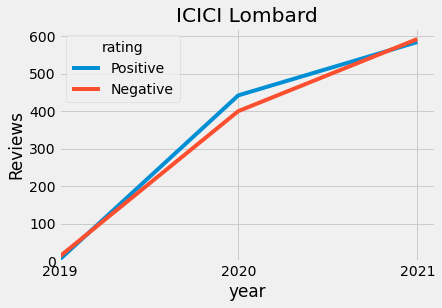

In [14]:
plot_company_year(company='icici_lombard', company_name='ICICI Lombard')

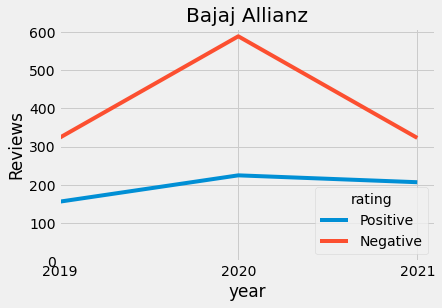

In [15]:
plot_company_year(company='bajaj_allianz', company_name='Bajaj Allianz')

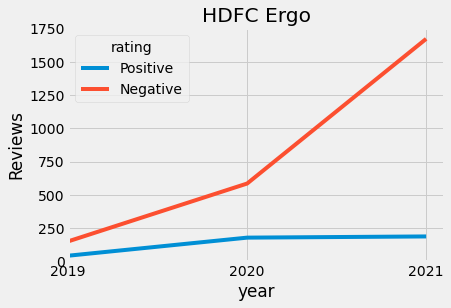

In [16]:
plot_company_year(company='hdfc_ergo', company_name = 'HDFC Ergo')

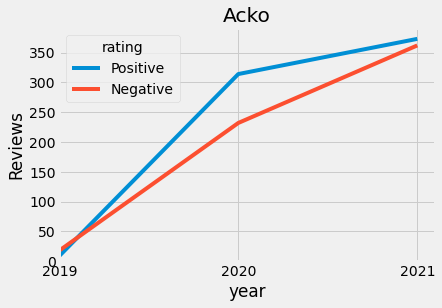

In [17]:
plot_company_year(company='acko', company_name='Acko')

Bajaj Allianz has significantly brought down negative reviews by half in 2021. While HDFC Ergo has a clear problem of almost 3 times increase in negative reviews in 2021. For ICICI Lombard & Acko, growth in negative reviews is in line with trend.

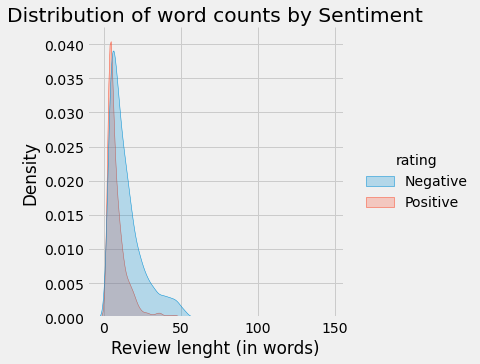

In [18]:
def count_words(text):
    tokens = word_tokenize(text)
    return len(tokens)

df_text['clean_review_len'] = df_text.clean_review.apply(count_words)
sns.displot(df_text, x="clean_review_len", hue='rating', kind="kde",fill=True)
plt.title('Distribution of word counts by Sentiment')
plt.xlabel('Review lenght (in words)');

As we had noted before, on an average, positive reviews are shorter in length. 

### Frequent words

What are the frequent words by overall & different sentiments ?

In [19]:
def top_frequent_ngram(text_column , ngram=1, top_n = 20):
    """
    returns top_n most frequent words from text data
    
    text_column - Pandas series containing text data
    ngram - contiguous sequence of words
    top_n - top frequent words to view
    
    """
    words = text_column.str.split().explode()
    top_words = None
    
    if ngram == 1:
        words_df = pd.DataFrame(words.value_counts())
        words_df = words_df.reset_index()
        words_df.columns = ['word','count']
        top_words = words_df.head(top_n)
        
    elif ngram <1 :
        print("Enter > 0 value for ngram ")
    
    else :
        ngrams = pd.Series(nltk.ngrams(words,ngram)).value_counts()
        df_ngram = pd.DataFrame(ngrams)
        df_ngram = df_ngram.reset_index()
        df_ngram.columns = ['word','count']
        top_words = df_ngram.head(top_n)

    return top_words


In [20]:
def plot_top_words(df, title):
    
    plt.figure(figsize=(6,8))
    sns.barplot(y=df['word'], x=df['count'])
    plt.title(title)
    plt.xticks(rotation=30, size=12)
    plt.show()

In [21]:
def plot_top_words(df, title, ax):
    
    sns.barplot(y=df['word'], x=df['count'], ax= ax)
    ax.set_title(title)


In [22]:
df_negative = df_text.loc[df_text.rating == 'Negative',]
df_top_neg_words = top_frequent_ngram(df_negative.clean_review, ngram=1, top_n=20)

df_positive = df_text.loc[df_text.rating == 'Positive',]
df_top_pos_words = top_frequent_ngram(df_positive.clean_review, ngram=1, top_n=20)

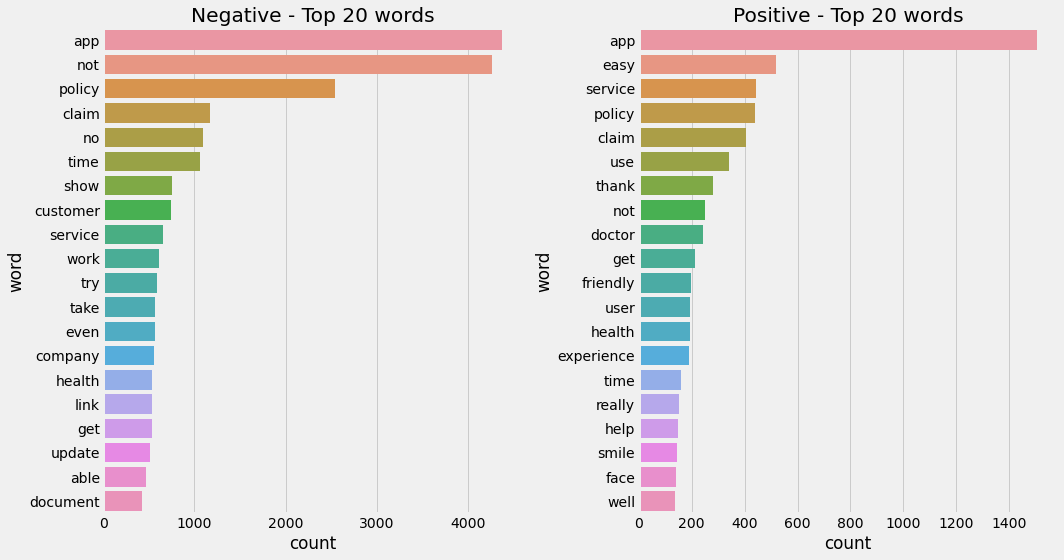

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'Negative - Top 20 words', ax1)
plot_top_words(df_top_pos_words, 'Positive - Top 20 words', ax2)
fig.tight_layout(w_pad=1) 

If we ignore app, not, and no, then we have below __negative__ top frequent words :
1. Policy
2. Claim
3. Time
4. Show
5. Customer/Service

If we ignore app, use and thank like generic words, then we have below __positive__ top frequent words :
1. Easy
2. Service
3. Policy
4. Claim
5. Doctor

Policy, Claims & Service are present in both the sentiments. Let us look at bigram & trigram for better understanding.

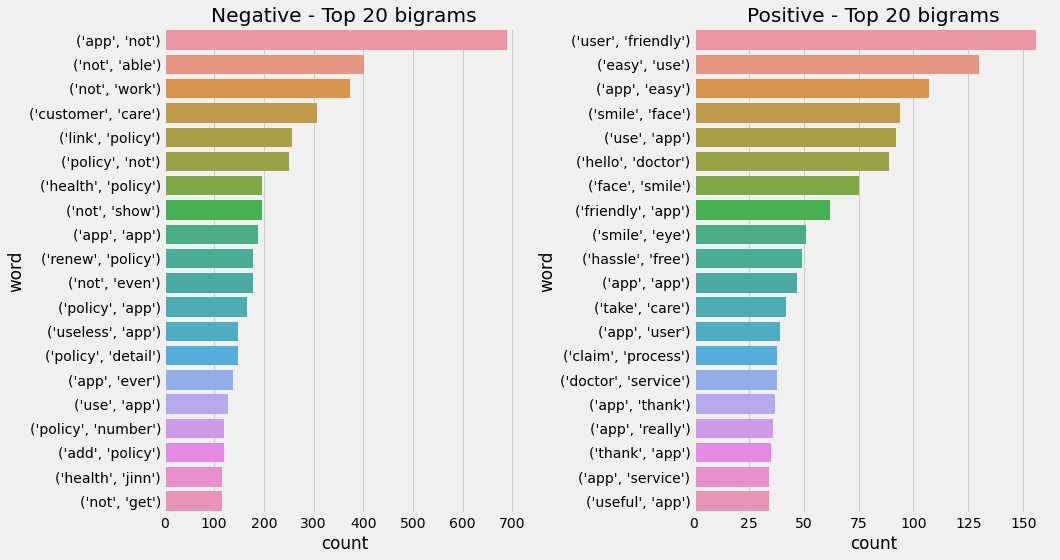

In [24]:
df_top_neg_words = top_frequent_ngram(df_negative.clean_review, ngram=2, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.clean_review, ngram=2, top_n=20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'Negative - Top 20 bigrams', ax1)
plot_top_words(df_top_pos_words, 'Positive - Top 20 bigrams', ax2)
fig.tight_layout(w_pad=1) 

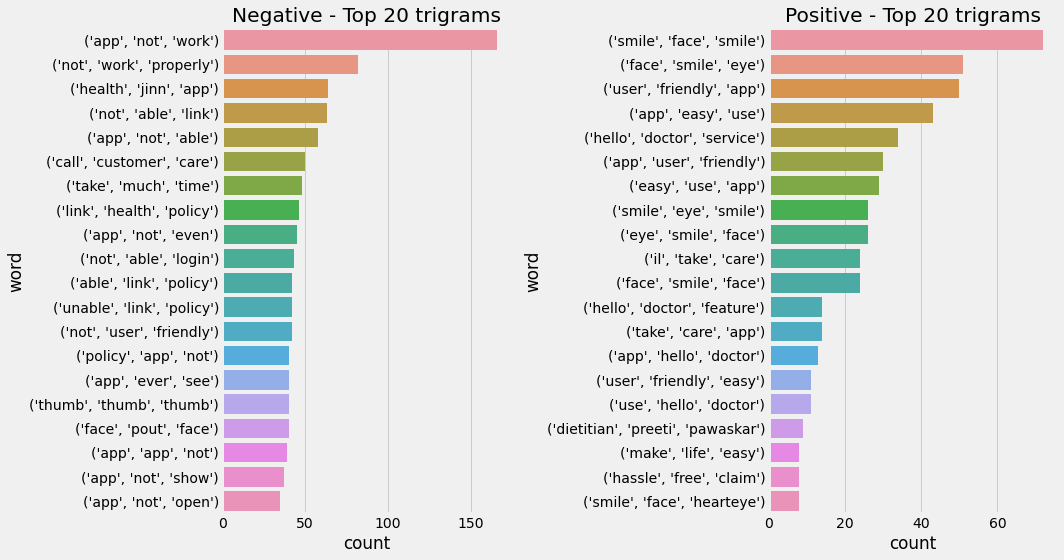

In [25]:
df_top_neg_words = top_frequent_ngram(df_negative.clean_review, ngram=3, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.clean_review, ngram=3, top_n=20)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'Negative - Top 20 trigrams', ax1)
plot_top_words(df_top_pos_words, 'Positive - Top 20 trigrams', ax2)
fig.tight_layout(w_pad=1) 

Based on top frequent words, biagrams & trigrams,  
following __factors are driving negative sentiments__
1. App is not functioning as per expectation.
2. App is slow.
3. Some customers are not able to login as well.
4. Customers are not able to link/renew policy.
5. Customers are not happy with the response of customer care to their queries.

and following __factors are driving positive sentiments__
1. Ease of use
2. Hello Doctor service/feature
3. Claims process

Hello Doctor is a tele-consultation service for health issue. It is provided by ICICI Lombard. We can clearly see that this value added service is well operational and customers are benefitting from it.   
source : https://www.outlookindia.com/outlookmoney/insurance/takecare-app-a-hit-with-customers-says-icici-lombard-7120  
On the other hand, Health Jinn was an app from Apollo Munich company which was later acquired by HDFC Ergo in Jan 2020. Customers were not happy with this app.    
source : https://www.apollomunichinsurance.com/miscellanous/download-health-jinn.aspx

### Top Unique words in each sentiment


In [26]:
def unique_words_by_sentiment(positive_text, negative_text, ngram=1, top_n = 20):
    
    positive_words = positive_text.str.split().explode()
    negative_words = negative_text.str.split().explode()
    
    unique_positive = set(positive_words) - set(negative_words)
    unique_negative = set(negative_words) - set(positive_words)
    
    
    df_pos_words = positive_words.loc[positive_words.isin(unique_positive)]
    df_top_pos_words = top_frequent_ngram(df_pos_words, ngram=1, top_n=top_n)

    df_neg_words = negative_words.loc[negative_words.isin(unique_negative)]
    df_top_neg_words = top_frequent_ngram(df_neg_words, ngram=1, top_n=top_n)

    return df_top_pos_words, df_top_neg_words

In [27]:
df_top_pos_words, df_top_neg_words = unique_words_by_sentiment(df_text.loc[df_text.rating == 'Positive','clean_review'],
                                                             df_text.loc[df_text.rating == 'Negative','clean_review'],
                                                             ngram=1, top_n =20 )

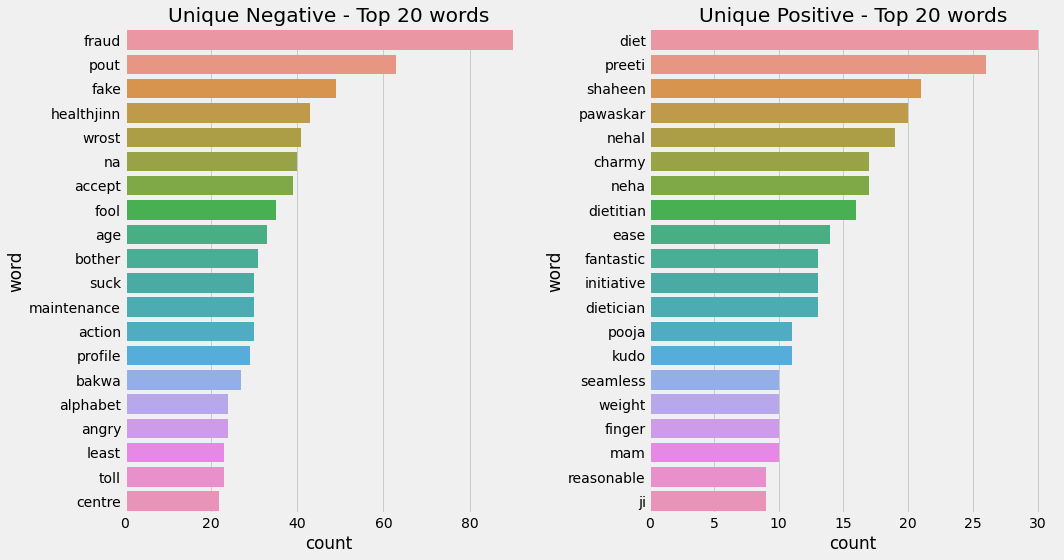

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)

plot_top_words(df_top_neg_words, 'Unique Negative - Top 20 words', ax1)
plot_top_words(df_top_pos_words, 'Unique Positive - Top 20 words', ax2)
fig.tight_layout(w_pad=1) 

Negative reviews contain generic words except Health Jinn. We see that diet consultation service is specifically mentioned in the positive review. This service is a part of Hello Doctor feature by ICICI Lombard. We also see names like preeti, shaheen etc mentioned frequently in reviews. Let us understand it more by looking at some reviews.

In [29]:
def find_word(text, search_word):
    x = [True if word == search_word else False for word in text.split()]
    return x.count(True) > 0


In [30]:
df_text.loc[df_text.clean_review.apply(find_word, args =('preeti',)), ['clean_review','company']].head(10)

,clean_review,company
563,dietitian preeti awesome instructor thumb thumb,icici_lombard
1176,health dmp program amazing app user friendlyi ...,icici_lombard
701,thank much preeti pawaskar session,icici_lombard
911,dietitian preeti pawaskar supportive,icici_lombard
1118,awsm experience proper chat diet preeti,icici_lombard
880,quite helpful suggestion provide team interact...,icici_lombard
371,app easy use chat dietitian preeti pawaskar re...,icici_lombard
1579,lovely app dmp program preeti mam give various...,icici_lombard
548,guide well diet plan ms preeti pawaskar,icici_lombard
935,dmp program effectivevery well advise execute ...,icici_lombard


In [31]:
df_text.loc[df_text.clean_review.apply(find_word, args =('shaheen',)), ['clean_review','company']].head(10)

,clean_review,company
466,shaheen explain app well easy use various faci...,icici_lombard
1140,suggest ms shaheen check ongoing health policy...,icici_lombard
140,helpful app guide shaheen,icici_lombard
1137,app wow slightly smile face make life easy eve...,icici_lombard
946,shaheen explain feature nicley use feature wor...,icici_lombard
1131,app much reliable refer shaheen,icici_lombard
1268,easy quick use refer shaikh shaheen,icici_lombard
1083,gud service easy use handy policy every one av...,icici_lombard
1274,thank guidance well discribe function shaheen ...,icici_lombard
953,experience instal app happy policy people empl...,icici_lombard


These are the names of either Dietician or customer executive of ICICI Lombard.  
1. Dieticians are helping customers on diet plan through online chat
2. Customer executives helped customers in installing the app and explained the app features.   
This strategy of increasing app adaptation and providing value added services seems to be working well for the company and customers.

In [32]:
df_text.loc[df_text.clean_review.apply(find_word, args =('healthjinn',)), ['clean_review','company']].head(10)

,clean_review,company
6338,nt show policy open refresh multiple time refl...,hdfc_ergo
7829,app hold health insuranse get notification hea...,hdfc_ergo
6633,healthjinn way well app slow not show detail e...,hdfc_ergo
6108,strategy get policy renew nt let customer logi...,hdfc_ergo
7064,app not add another health policy mobile numbe...,hdfc_ergo
7867,install app keep load try multiple time thing ...,hdfc_ergo
5771,healthjinn app shutdown per app instruction do...,hdfc_ergo
7134,vahiyaat app bakawa bogus kyun khoon pi rahe h...,hdfc_ergo
7031,keep load time healthjinn well deprecate healt...,hdfc_ergo
6148,app suck finish lunch dinner follow bath till ...,hdfc_ergo


Let's look at bigrams by each company.

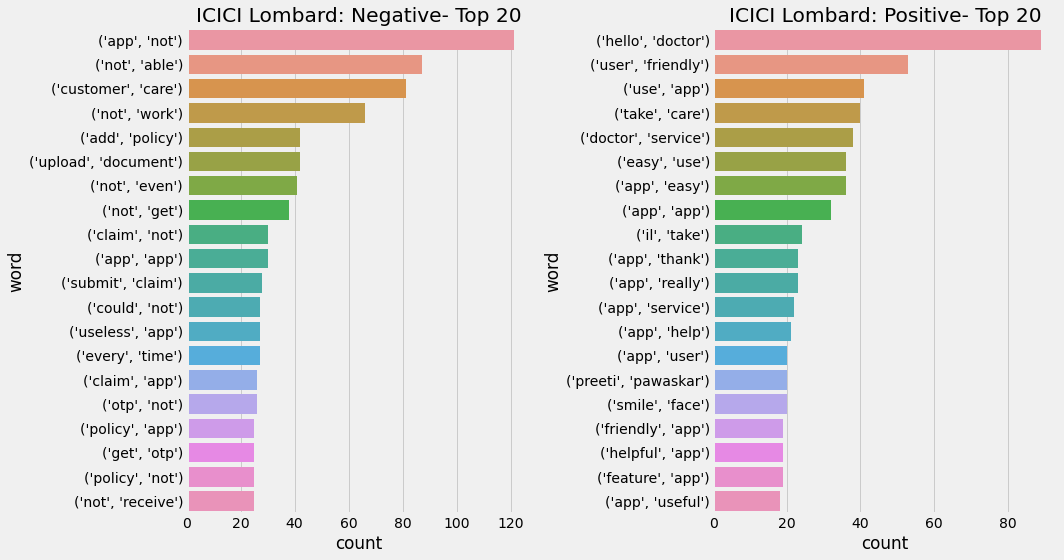

In [33]:
df_top_neg_words = top_frequent_ngram(df_negative.loc[df_negative.company == 'icici_lombard', 'clean_review'],
                                      ngram=2, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.loc[df_positive.company == 'icici_lombard', 'clean_review'],
                                      ngram=2, top_n=20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'ICICI Lombard: Negative- Top 20', ax1)
plot_top_words(df_top_pos_words, 'ICICI Lombard: Positive- Top 20', ax2)
fig.tight_layout(w_pad=1) 

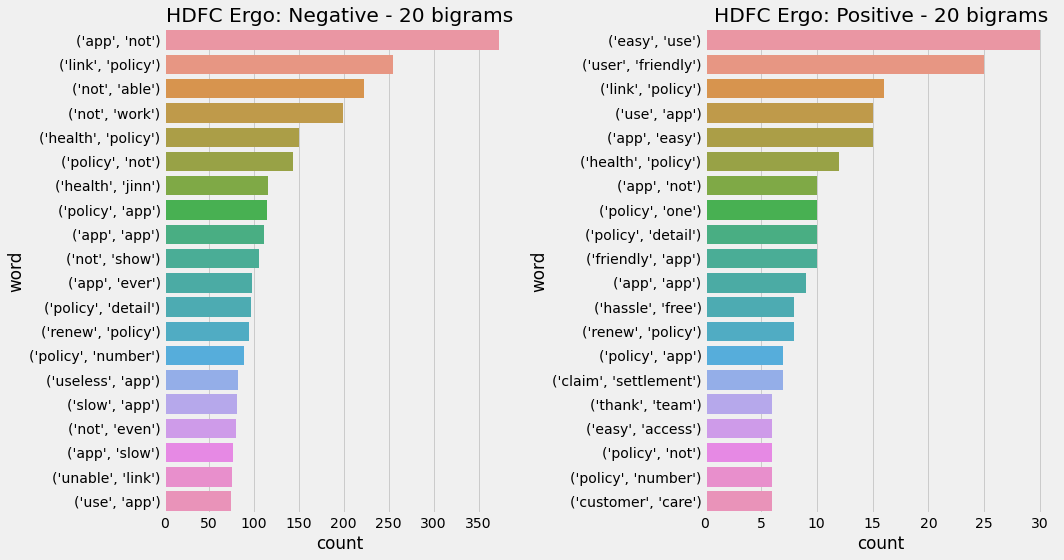

In [34]:
df_top_neg_words = top_frequent_ngram(df_negative.loc[df_negative.company == 'hdfc_ergo', 'clean_review'],
                                      ngram=2, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.loc[df_positive.company == 'hdfc_ergo', 'clean_review'],
                                      ngram=2, top_n=20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'HDFC Ergo: Negative - 20 bigrams', ax1)
plot_top_words(df_top_pos_words, 'HDFC Ergo: Positive - 20 bigrams', ax2)
fig.tight_layout(w_pad=1) 

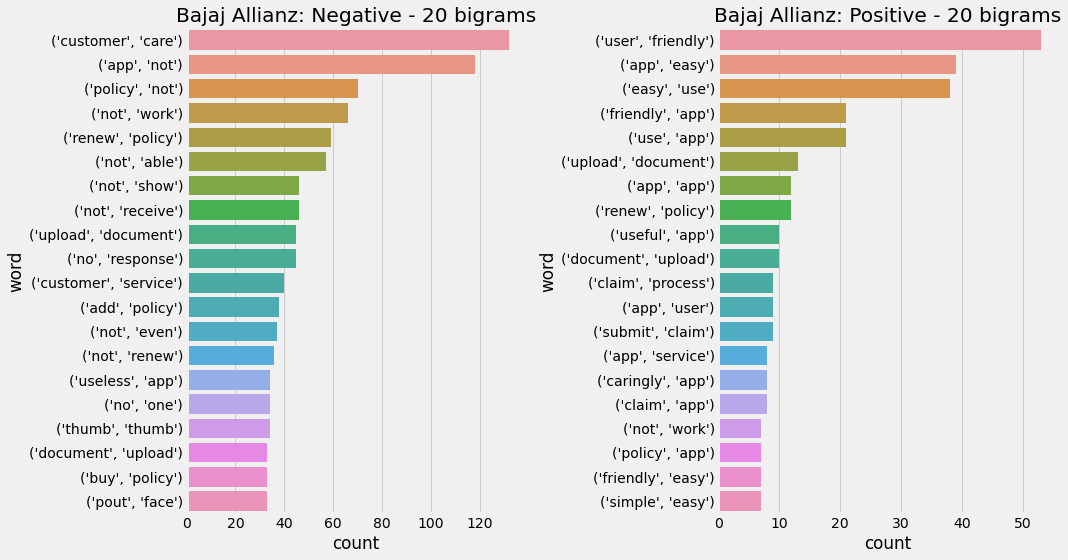

In [35]:
df_top_neg_words = top_frequent_ngram(df_negative.loc[df_negative.company == 'bajaj_allianz', 'clean_review'],
                                      ngram=2, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.loc[df_positive.company == 'bajaj_allianz', 'clean_review'],
                                      ngram=2, top_n=20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'Bajaj Allianz: Negative - 20 bigrams', ax1)
plot_top_words(df_top_pos_words, 'Bajaj Allianz: Positive - 20 bigrams', ax2)
fig.tight_layout(w_pad=1) 

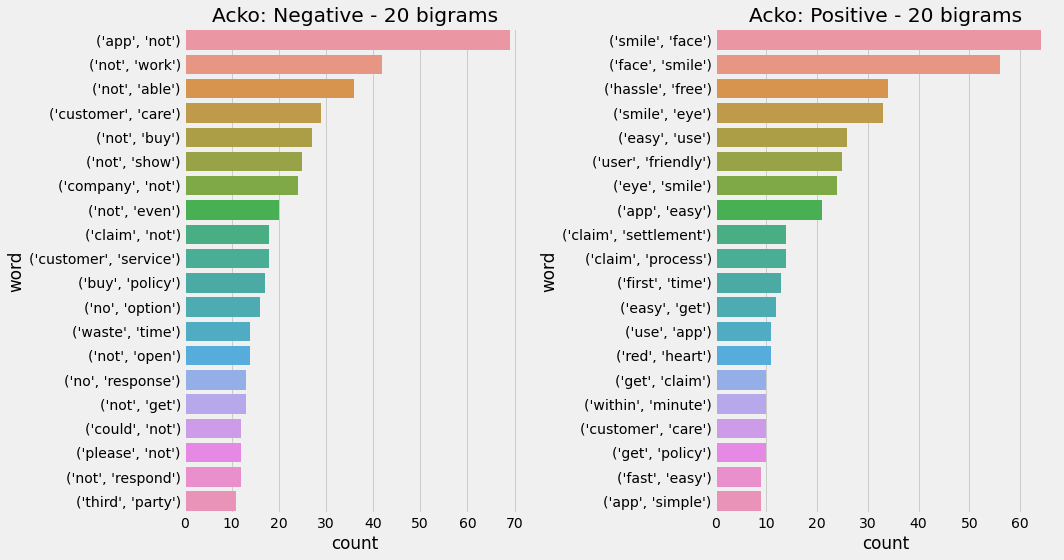

In [36]:
df_top_neg_words = top_frequent_ngram(df_negative.loc[df_negative.company == 'acko', 'clean_review'],
                                      ngram=2, top_n=20)
df_top_pos_words = top_frequent_ngram(df_positive.loc[df_positive.company == 'acko', 'clean_review'],
                                      ngram=2, top_n=20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=15, h = 8)
plot_top_words(df_top_neg_words, 'Acko: Negative - 20 bigrams', ax1)
plot_top_words(df_top_pos_words, 'Acko: Positive - 20 bigrams', ax2)
fig.tight_layout(w_pad=1) 

All companies are facing issues same issues as mentioned before. Company wise trends in frequent words are almost the same as overall trends with few exceptions.  

1. ICICI Lombard - Hello Doctor feature is the top positive frequent word and specific to ICICI Lombard.
2. Bajaj Allianz - Customer Service is worse than app related issues.

This completes EDA and we will save the data for modelling exercise.

In [37]:
df_train.shape, df_test.shape

((7980, 14), (2660, 14))

In [38]:
train_review = '../data/interim/train_review.csv'
df_train.to_csv(train_review,  index=None, header=True)

In [39]:
test_review = '../data/interim/test_review.csv'
df_test.to_csv(test_review,  index=None, header=True)